# Classify pattern defects of Rayleigh-Benard convection

This notebook uses SIFT feature vectors and Hough transform voting to find matches from a dictionary of defects in input patterns. The info for the Hough transform voting is from http://conf-scoop.org/IWIP-2014/4.V.Seib_IWIP.pdf

In [8]:
import numpy as np
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from scipy import spatial

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline  

## Set up local environment variables

In [9]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
roll_width = 30 # Width of a single roll
crop_radius = 210-roll_width # Radius of circular crop
keypoint_orientation_bins = 19


sFeatureVectors = ['/r4000_2016_11_01_superfast/g21flow/feature_vectors/%06d.txt', '/r4000_2016_11_01_superfast/g21flow_4000/feature_vectors/%06d.txt']
sBmp = ['/r4000_2016_11_01_superfast/g21flow/bmps/%06d.bmp', '/r4000_2016_11_01_superfast/g21flow_4000/bmps/%06d.bmp']

sFeatureVectors[1] = sFeatureVectors[0]
sBmp[1] = sBmp[0]

## Set up variables for local defect computations

In [10]:
radius = roll_width

## Utility functions

In [11]:
def loadData(idx, dataset):
    
    # Get feature vectors
    fv = pd.read_csv(sDir + "/" + (sFeatureVectors[dataset] % idx), sep=' ', header=None)
    fv = np.asarray(fv.astype(np.int16))
    fv[:,15] = fv[:,15]*10
    fv = np.hstack((np.ones((fv.shape[0],1))*idx, fv)) # Add frame number
    
    # Get bitmap image
    bmp = misc.imread(sDir + "/" + sBmp[dataset] % idx)
    
#     # Persistent homology H1 generators (for spiral/target disambiguation)
#     ph_features_sub = pd.read_csv(sDir + "/" + (sSubPD % idx))
#     ph_features_sub = pd.DataFrame(ph_features_sub)
    
#     # Persistent homology upper saddle points
#     ph_features_sup = pd.read_csv(sDir + "/" + (sSupPD % idx))
#     ph_features_sup = pd.DataFrame(ph_features_sup)

    return (fv, bmp)


In [12]:
def computeMatch(_location, _fv1, _fv2, _radius, _location_bins, _rotation_bins, _cutoff, _num_features_factor, _makeplots):
    """Compute the distance between two patterns based on their keypoint features.
    Based on using Hough transform voting to find clusters of matches which align with the same
    relative orientation to the center of the pattern.

    Arguments:
    location1 -- the (x,y) location of the first pattern center
    fv1 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the first pattern
    fv2 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the second pattern
    """
    
    boxradius = _radius # For Hough transform
    
    ht_vectors = []
    ht_accumulator = []
    
    feature_index = 16
    
    x1 = int(_location[0])
    y1 = int(_location[1])
    time1 = int(_fv1[0,0])
    time2 = int(_fv2[0,0])
    
    _fv2 = np.hstack((_fv2, np.reshape(np.asarray(range(_fv2.shape[0])),(_fv2.shape[0],1))))
    
    if _makeplots:
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.subplot(1,2,1)
        bmp1 = bmps[time1][(y1-boxradius):(y1+boxradius), (x1-boxradius):(x1+boxradius)]
        plt.imshow(bmp1)
        plt.scatter(_fv1[:,4] - x1 + boxradius, _fv1[:,5] - y1 + boxradius, color='white', edgecolor='black')
        
        plt.subplot(1,2,2)
        bmp2 = bmps[time2]
        plt.imshow(bmp2)
        plt.scatter(_fv2[:,4], _fv2[:,5], color='white', edgecolor='black')
        
        plt.show()
    
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
    
    _dist = 300
    
    
    # Match on the local keypoint descriptor
    # Loop through the features in the second feature vector
    for i in range(_fv1.shape[0]):
        
        if _makeplots:
            print "Feature #%d" % i
        
        # Only keypoints with same type should be matched
        keypoint_type = np.argwhere(_fv1[i,6:14]==1)
        fv2_sametype = _fv2[np.where(_fv2[:,keypoint_type+6]==1)[0], :]
        
        # If there's at least one keypoint with the same type:
        if len(fv2_sametype)>0:
            
            allfv = np.vstack((np.hstack((_fv1[i,:],[0])), fv2_sametype))
            allfv = allfv[:,feature_index:]

            # Get the nearest neighbors
            num_neighbors = 10
            distmat = spatial.distance.pdist(allfv[:,:-1])
            distmat = spatial.distance.squareform(distmat)
            sorted_distances = sorted((e,i) for i,e in enumerate(distmat[0,1:]))
            sorted_distances = np.asarray(sorted_distances)
            nn = sorted_distances[0:num_neighbors, :]

            
            if _makeplots:
                print nn.T
                bmp0 = bmps[time1][(_fv1[i,5] - boxradius):(_fv1[i,5] + boxradius), (_fv1[i,4] - boxradius):(_fv1[i,4] + boxradius)]
                plt.subplot(1,num_neighbors+1,1)
                plt.imshow(bmp0);
                plt.scatter(boxradius, boxradius, color='white', edgecolor='black');
            
            display_neighbors = 10
            for n in range(min(display_neighbors, len(nn[:,0]))):
                matched_nn = fv2_sametype[nn[n,1],:]
                
                if _makeplots:
                    bmp_match = bmps[time2][(matched_nn[5] - boxradius):(matched_nn[5] + boxradius), (matched_nn[4] - boxradius):(matched_nn[4] + boxradius)]

                    plt.subplot(1,num_neighbors+1,n+2)
                    plt.imshow(bmp_match);
                    plt.scatter(boxradius, boxradius, color='white', edgecolor='black');

            if _makeplots:
                plt.show();
                
            # Do the Hough transform stuff
            # Get the nearest neighbor distance
            cutoff_distance = nn[0,0] + _cutoff
            
            nn = nn[nn[:,0]<= cutoff_distance,:]
            
            for this_nn in range(nn.shape[0]):
                
                nbr = nn[this_nn,:]

                # For this nearest neighbor
                matched_nn = fv2_sametype[nbr[1],:]

                # Get the translation vector from the original image
                v_prime = [x1, y1] - _fv1[i,4:6]

                # Rotate by the orientations
                alpha = math.radians(abs(_fv1[i,14] - matched_nn[14])*(180./keypoint_orientation_bins))
                v = np.dot(np.asarray([[math.cos(alpha), -math.sin(alpha)], [math.sin(alpha), math.cos(alpha)]]), v_prime)

                # Compute the estimated centroid of the matched image
                c_s = v + matched_nn[4:6]

                # Bin the centroid values
                c_accum = np.floor(c_s*(float(_location_bins)/421.))

                c_accum_p1 = c_accum + 1
                c_accum_p1 = c_accum - 1

                # Get the orientation vote
                i_r_prime = (alpha + math.pi)*_rotation_bins*(1./(2.*math.pi))

                # Bin it
                r_accum = math.floor(i_r_prime) % _rotation_bins
                r_accum_p1 = math.floor(i_r_prime+1) % _rotation_bins
                

                # Make a vector out of it
                accum = np.hstack(( [i], c_accum, c_accum_p1, [r_accum], [r_accum_p1], [nbr[0]], matched_nn[4:6], c_s, matched_nn[-1:]))

                # Add it to the hough transform vector
                if len(ht_vectors) == 0:
                    ht_vectors = accum

                else:
                    ht_vectors = np.vstack((ht_vectors, accum))

                # Add it to the hough transform accumulator
                for _x in [1,3]:
                    for _y in [2,4]:
                        for _r in [5,6]:
                            if len(ht_accumulator) == 0:
                                ht_accumulator = np.hstack((np.asarray([accum[0], accum[_x], accum[_y], accum[_r]]), accum[7:13]))
                            else:
                                ht_accumulator = np.vstack((ht_accumulator, np.hstack((np.asarray([accum[0], accum[_x], accum[_y], accum[_r]]), accum[7:13]))))
    
    ret_values = []
        
    if len(ht_accumulator) > 0:
        
        # Get the bins with enough qualified votes: _num_features_factor*_fv1.shape[0]
        
        tmp_accumulator = ht_accumulator[:,1:4]
        b = np.ascontiguousarray(tmp_accumulator).view(np.dtype((np.void, tmp_accumulator.dtype.itemsize * tmp_accumulator.shape[1])))
        _, idx, counts = np.unique(b, return_index=True, return_counts=True)
        top_ht = np.argsort(counts)
        
        counts = counts[top_ht][::-1]
        qualified_counts = (counts >= _num_features_factor*_fv1.shape[0])

        
        # Check to make sure some bins qualify
        if counts[qualified_counts].shape[0] > 0:
        
            sorted_accumulator = np.hstack((tmp_accumulator[idx[top_ht],:][::-1][qualified_counts], np.reshape(counts[qualified_counts].T, (counts[qualified_counts].shape[0],1))))            
            sorted_accumulator = np.hstack((sorted_accumulator, np.ones((sorted_accumulator.shape[0],1))))
                        
            # Loop through all of these and collect up matches
            while sum(sorted_accumulator[:,-1]) > 0:

                highest_bin = sorted_accumulator[sorted_accumulator[:,-1]>0,:][0,0:(sorted_accumulator.shape[1]-2)]
                
                # Get all the bins that are within one sup-norm distance away
                subtract_bin = np.matlib.repmat(highest_bin, tmp_accumulator.shape[0], 1)
                differences = np.abs(tmp_accumulator - subtract_bin)
                close_bins = ht_accumulator[np.argwhere(np.max(differences, axis=1)<=1),:]

                # Get the records corresponding to those bin values
                matching_records = np.reshape(close_bins, (close_bins.shape[0], close_bins.shape[2]))
                matching_records = matching_records[:,[0, -6, -5, -4, -3, -2, -1]]
                tmp_matching_records = np.ascontiguousarray(matching_records).view(np.dtype((np.void, matching_records.dtype.itemsize * matching_records.shape[1])))
                _, idx = np.unique(tmp_matching_records, return_index=True)

                # Get the corresponding features and take the average distance and centroid
                matched_features = matching_records[idx, :]
                
                num_unique_matched = len(set(matched_features[:,0].tolist()))
                
                if num_unique_matched >= _num_features_factor*_fv1.shape[0]:

                    _dist = np.median(matched_features[:,1])
                    _loc = np.mean(matched_features[:,[-3, -2]], axis=0)

                    # Get the number of keypoints in the radius neighborhood of this location in the matched pattern

                    # Get the features that are within the radius of the locations
                    k2 = spatial.KDTree(_fv2[:, 4:6])

                    # Get 50 nearest neighbors within radius
                    nn2 = k2.query(_loc, k=50, distance_upper_bound=_radius)

                    # Remove infinite matches
                    nn2 = nn2[1]
                    nn2 = nn2[(nn2<_fv2.shape[0])]

                    # Make sure enough are matched
                    if num_unique_matched >= _num_features_factor*nn2.shape[0]:

                        if _makeplots:

                            plt.rcParams['figure.figsize'] = (10.0, 10.0)
                            plt.imshow(bmp2)
                            plt.scatter(matched_features[:,2].astype(int), matched_features[:,3].astype(int), color='white', edgecolor='black')
                            plt.scatter(_loc[0], _loc[1], color='black', edgecolor='black')
#                             plt.scatter(_fv2[nn2,4], _fv2[nn2,5], color='red')
                            plt.show()

                        ret_values.append([_dist, _loc[0], _loc[1], len(idx)])


                # Mark bins as processed
                subtract_bin = np.matlib.repmat(highest_bin, sorted_accumulator.shape[0], 1)
                differences = np.abs(sorted_accumulator[:,0:-2] - subtract_bin)
                sorted_accumulator[np.argwhere(np.max(differences, axis=1)<=1),-1] = 0


        else:
            
        
            if _makeplots:

                plt.rcParams['figure.figsize'] = (10.0, 10.0)
                plt.imshow(bmp2)
                plt.show()
                
    
    return np.asarray(ret_values)

## Compute the distances between patterns from two nearby images

In [6]:
t1 = 1530
t2 = 1100

bmps = {}
features = []

for idx in [t1, t2]:

    fv, bmp = loadData(idx, 0)
    
    # Add bitmap image to dictionary, where idx is the key and the bitmap is the value
    bmps[idx] = bmp
    
    if len(features) == 0:
        features = fv
    else:
        features = np.vstack([features, fv])

features = features.astype(np.int16)

features1 = features[(features[:,0] == t1)]
features2 = features[(features[:,0] == t2)]
print features1.shape, features2.shape

(119, 113) (117, 113)


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([  3,  13,  15,  39,  43,  44,  46,  47,  49,  98, 105]))


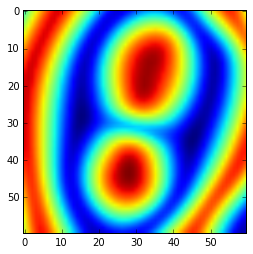

In [7]:
x = 300
y = 163


radius = 30

x = [x - radius, x+radius]
y = [y - radius, y+radius]


bmp_cropped = bmps[t1][y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)

print np.where([(features1[:,4] >= x[0]) & (features1[:,4] <= x[1]) & (features1[:,5] >= y[0]) & (features1[:,5] <= y[1])])

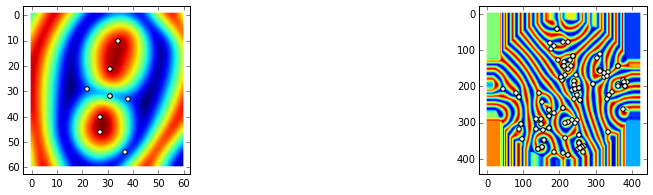

Feature #0
[[ 193.88914358  267.99626863  278.49057435  296.54679226  306.87456721
   348.51685755  428.52071128  453.17546271  491.11913015  491.69807809]
 [  10.           11.            8.            6.            7.            5.
     9.            4.            1.            3.        ]]


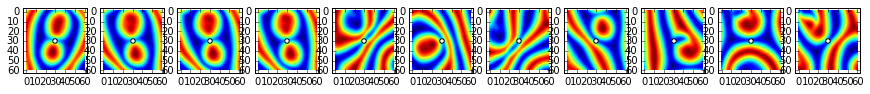

Feature #1
[[ 214.36417611  231.93749158  236.34085555  301.90395824  320.8317316
   323.31254229  412.62210314  447.60138516  457.29640278  508.07184531]
 [   8.            6.           11.           10.            5.            7.
     9.            4.            3.            0.        ]]


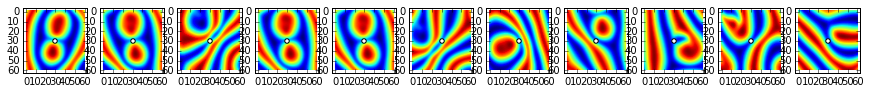

Feature #2
[[ 225.02222112  329.38579204  344.40528451  365.29850807  400.43226643
   508.82118667  547.57282621  564.26943919  568.5877241   568.63081169]
 [  26.           18.           34.           16.           44.           22.
    45.            3.           49.           27.        ]]


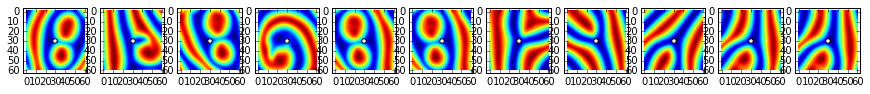

Feature #3
[[ 279.53532872  297.65248193  304.63256556  338.72850485  363.64405674
   455.78284303  497.8875375   505.17719664  512.06542551  522.60118637]
 [  44.           26.           34.           18.           16.           49.
    45.            3.           22.            9.        ]]


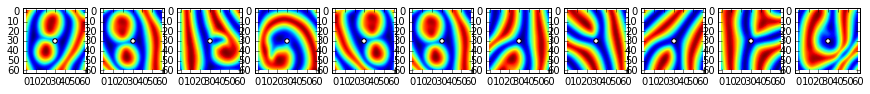

Feature #4
[[ 112.39661917  136.02205703  172.32237231  179.37391115  183.57015008
   187.90955271  194.81786366  231.83614904  247.23268392  259.09843689]
 [  13.           24.           15.           10.           28.           17.
    23.           25.           30.           36.        ]]


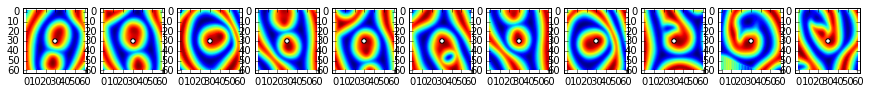

Feature #5
[[ 150.1099597   161.16761461  166.28289148  171.82549287  182.40065789
   186.29278032  199.32385708  212.7157728   242.53659518  247.18414189]
 [  10.           13.           28.           23.           24.           15.
    17.           30.           21.           25.        ]]


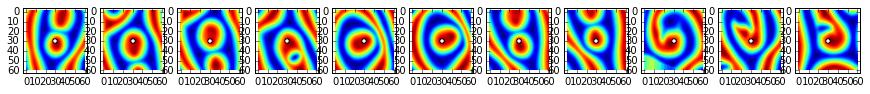

Feature #6
[[ 160.73269736  169.88819853  171.21623755  171.46428199  179.80545042
   193.52777578  203.02216628  203.73512216  221.03845819  260.64151626]
 [  13.           28.           10.           24.           23.           15.
    30.           17.           25.           36.        ]]


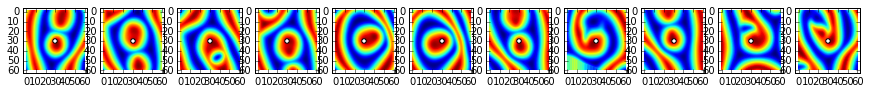

Feature #7
[[ 120.12493496  158.59066807  170.06469357  188.28967045  190.6960933
   197.80545999  201.19642144  240.5514498   246.20519897  247.22257179]
 [  13.           24.           10.           17.           23.           28.
    15.           25.           30.           36.        ]]


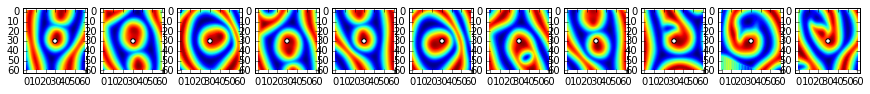

Feature #8
[[ 141.66156854  149.10734388  156.42889759  171.67702234  201.64572894
   203.46006979  205.01707246  206.9081922   217.40285187  228.93667247]
 [  28.           10.           23.           15.           26.           24.
    17.           13.           30.           21.        ]]


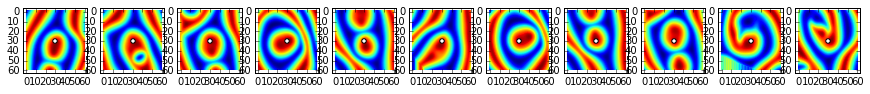

Feature #9
[[ 103.16491652  195.96938536  214.85343842  275.78977501  283.78160617
   283.87321113  325.28141662  378.01322728  415.37814098  416.16823521]
 [   3.            0.            9.            5.            1.            4.
     2.            6.            8.           11.        ]]


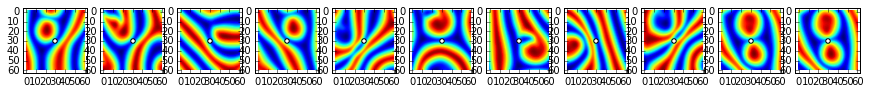

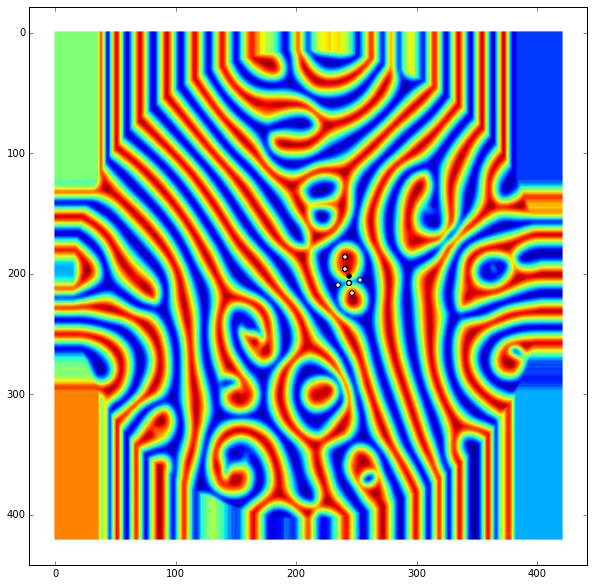

[[ 193.88914358  243.89569137  201.93313524   17.        ]]


In [9]:

location1 = np.asarray([np.average(x), np.average(y)])

# Get the features that are within the radius of the locations
k1 = spatial.KDTree(features1[:, 4:6])

# Get 50 nearest neighbors within radius
nn1 = k1.query(location1, k=50, distance_upper_bound=radius)

# Remove infinite matches
nn1 = nn1[1]
nn1 = nn1[(nn1<features1.shape[0])]

f1 = features1[nn1]
f2 = features2

matches = computeMatch(location1, f1, f2, radius, 40, 8, 100, .75, 1)

print matches

## Compute matches for a single pattern across a dataset

<function matplotlib.pyplot.show>

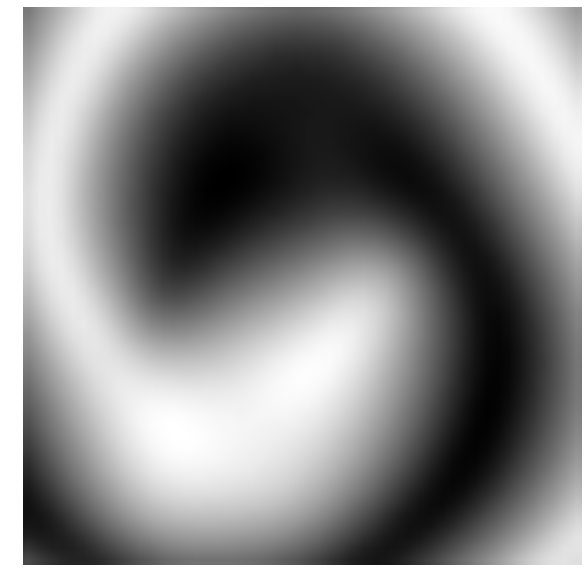

In [17]:
presets = [[1330, 348, 147], [1400, 375, 195], [1525, 142, 220], [1165, 242, 190], [1860, 226, 120], \
           [1100, 364, 196], [1035, 245, 205], [1055, 150, 360], [1485, 300, 163], [2850, 160, 350], \
           [1970, 160, 360]]

# Preset catalog
# 0 = grain boundary
# 1 = plume next to bridge
# 2 = concave disclination
# 3 = dimple formation
# 4 = thin bridge
# 5 = plume formation
# 6 = figure eight
# 7 = right-handed spiral
# 8 = other figure eight
# 9 = continuation of (7) at frame 2800
# 10 = continuation of (7) at frame 1970

preset_idx = 10
radius = 25

t1 = presets[preset_idx][0]
x = presets[preset_idx][1]
y = presets[preset_idx][2]

x = [x-radius, x+radius]
y = [y-radius, y+radius]

features1, bmp1 = loadData(t1, 0)
features1 = np.asarray(features1)

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
bmp_cropped = bmp1[y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)
plt.axis('off')
plt.show

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (3.0, 3.0)
plt.imshow(bmp1)
plt.axis('off')
plt.show



In [12]:
location1 = np.asarray([np.average(x), np.average(y)])

# Get the features that are within the radius of the locations
k1 = spatial.KDTree(features1[:, 4:6])

# Get 50 nearest neighbors within radius
nn1 = k1.query(location1, k=50, distance_upper_bound=radius)

# Remove infinite matches
nn1 = nn1[1]
nn1 = nn1[(nn1<features1.shape[0])]

f1 = features1[nn1]

print f1.shape

(2, 113)


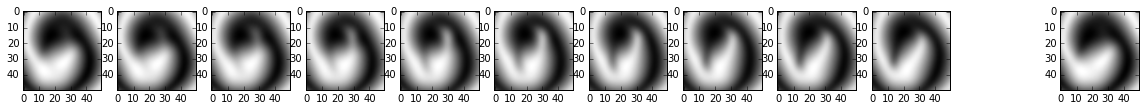

In [16]:
range_search_indices = range(t1, t1+51, 5)

f1 = {}

plt.rcParams['figure.figsize'] = (20.0, 3.0)

for pattern_idx in range_search_indices:
    
    features1, bmp1 = loadData(pattern_idx, 0)
    features1 = np.asarray(features1)
    
    # Get the features that are within the radius of the locations
    k1 = spatial.KDTree(features1[:, 4:6])

    # Get 50 nearest neighbors within radius
    nn1 = k1.query(location1, k=50, distance_upper_bound=radius)

    # Remove infinite matches
    nn1 = nn1[1]
    nn1 = nn1[(nn1<features1.shape[0])]

    f1[pattern_idx] = features1[nn1]
    
    bmp_match = bmp1[y[0]:y[1], x[0]:x[1]]

    plt.subplot(1,len(range_search_indices)+1,(pattern_idx-t1)/5)
    plt.imshow(bmp_match);
    
print

plt.show();

In [46]:
output_matches = [0, 0, 0, 0, 0]

print_cutoff = 150
range_indices = range(1, 5000)

for t2 in range_indices:
    
    if t2 % 10 == 0:
        print t2
    
    for pattern_idx in range_search_indices:

        features2, bmp2 = loadData(t2, 1)
        features2 = np.asarray(features2)

        matches = computeMatch(location1, f1[pattern_idx], features2, radius, 40, 8, 100, .9, 0)

        if (matches.shape[0] > 0):

            for i in range(matches.shape[0]):

                dist =  matches[i,0]

                output_matches = np.vstack((output_matches, [t2,dist,matches[i,1],matches[i,2], pattern_idx]))

    #             if dist <= print_cutoff:

    #                 plt.set_cmap('gray')
    #                 bmp_cropped = bmp2[(matches[i,2]-radius):(matches[i,2]+radius), (matches[i,1]-radius):(matches[i,1]+radius)]
    #                 plt.imshow(bmp_cropped)

    #                 plt.gca().xaxis.set_major_locator(plt.NullLocator())
    #                 plt.gca().yaxis.set_major_locator(plt.NullLocator())

    #                 plt.axis('off')

    #                 plt.show()

    
#                 print t2, dist, matches[i,1:3], pattern_idx

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [51]:

output_matches_2 = np.loadtxt(sDir + "/" +'r4000_2016_11_01_superfast/g21flow/search_patterns/preset_7_right_hand_spiral_new_vectors/output_matches.txt')
output_matches_3 = np.loadtxt(sDir + "/" +'r4000_2016_11_01_superfast/g21flow/search_patterns/preset_9_right_hand_spiral_continuation_new_vectors/output_matches.txt')
output_matches_4 = output_matches

output_matches = np.vstack((output_matches_2, output_matches_3[1:,:], output_matches_4[1:,:]))

(-10, 700)

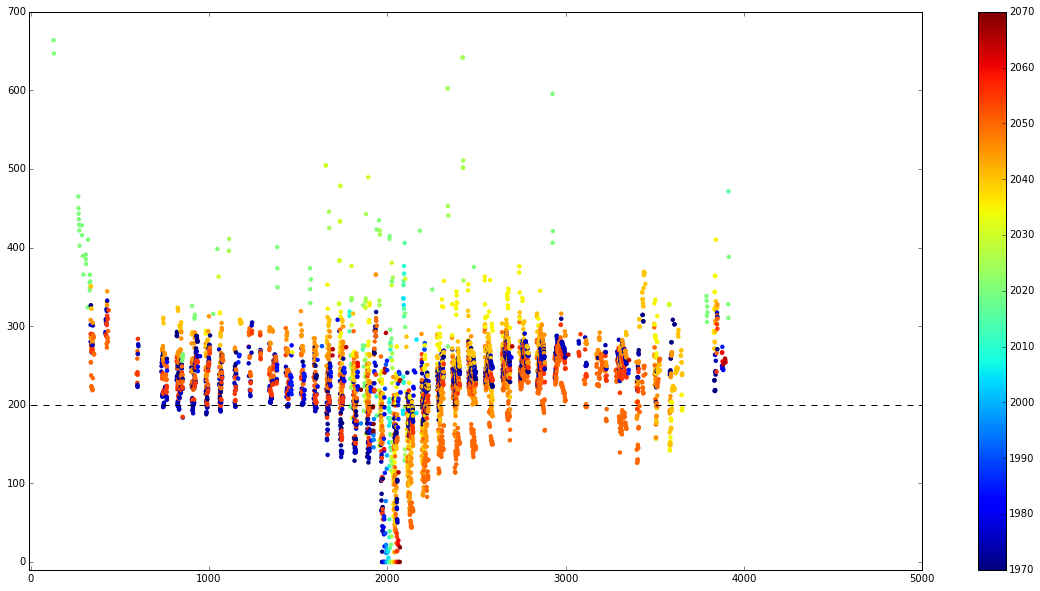

In [58]:

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.scatter(output_matches_4[1:,0], output_matches_4[1:,1], c=output_matches_4[1:,4], s=20, cmap=plt.cm.jet, linewidth=0)

plt.colorbar(ticks=range(1000, 5000, 10))

plt.plot([1, 5000], [200, 200], '--k', linewidth=1)
plt.xlim([-10, 5000])
plt.ylim([-10, 700])



<matplotlib.colorbar.Colorbar instance at 0x11171a950>

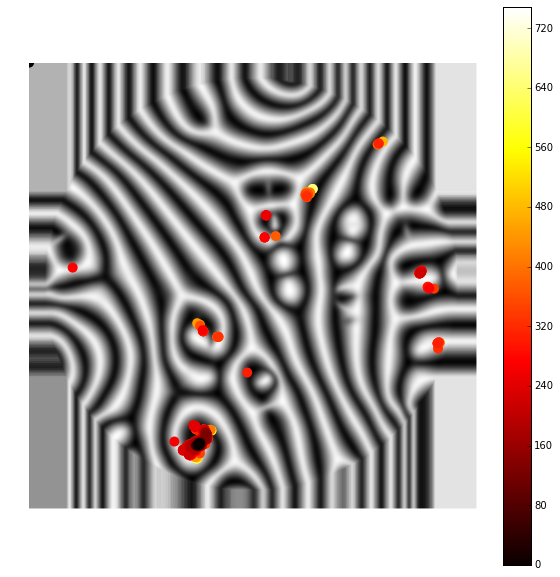

In [48]:
fv, bmp = loadData(2031, 0)

output_matches_sorted = output_matches[output_matches[:,1].argsort()][::-1]

plt.rcParams['figure.figsize'] = (10.0, 10.0)

plt.set_cmap('gray')
plt.imshow(bmp)
plt.scatter(output_matches_sorted[1:,2], output_matches_sorted[1:,3], c=output_matches_sorted[1:,1], cmap=plt.cm.hot, s=100, linewidth=0)
plt.ylim([0,421])
plt.xlim([0,421])

plt.gca().invert_yaxis()
plt.axis('off')

plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x1123ca950>

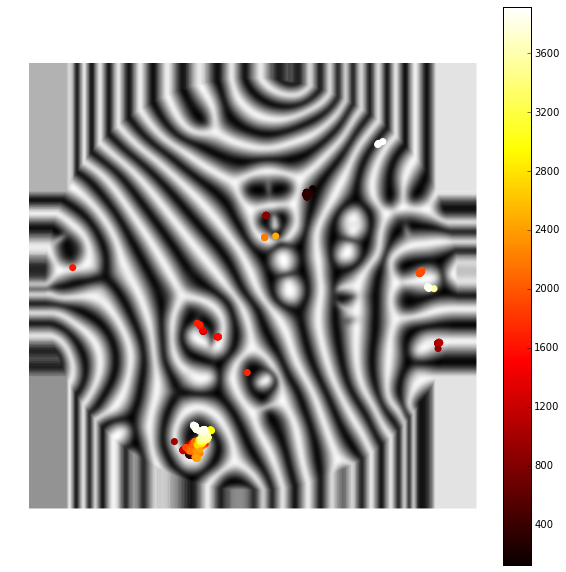

In [49]:
fv, bmp = loadData(2031, 0)

output_matches_sorted = output_matches

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(bmp)
plt.scatter(output_matches_sorted[1:,2], output_matches_sorted[1:,3], c=output_matches_sorted[1:,0], cmap=plt.cm.hot, s=50, linewidth=0)
plt.ylim([0,421])
plt.xlim([0,421])

plt.gca().invert_yaxis()
plt.axis('off')

plt.colorbar()

In [50]:
np.savetxt(sDir + "/" +'r4000_2016_11_01_superfast/g21flow/search_patterns/preset_10_right_hand_spiral_continuation/output_matches.txt', output_matches, fmt='%0.2f')

## Generate a distance matrix based on Hough transform distance

In [ ]:
presets = [[1085, 120, 330], [1525, 135, 225]]

# Preset catalog
# 0 = Lower-left right-handed spiral
# 1 = Center-left left-handed spiral

preset_idx = 0

t1 = presets[preset_idx][0]
x = presets[preset_idx][1]
y = presets[preset_idx][2]

x = [x, x+2*radius]
y = [y, y+2*radius]

features1, bmp1 = loadData(t1, 0)
features1 = np.asarray(features1)

plt.rcParams['figure.figsize'] = (3.0, 3.0)
bmp_cropped = bmp1[y[0]:y[1], x[0]:x[1]]
plt.imshow(bmp_cropped)
plt.show

In [ ]:

print_cutoff = 250
index_range = range(1000, 2000)

location = np.asarray([np.average(x), np.average(y)])

distmat = np.zeros((len(index_range),len(index_range)))

for t1 in range(len(index_range)):
    
    print index_range[t1]

    features1, bmp1 = loadData(index_range[t1], 0)
    features1 = np.asarray(features1)

    # Get the features that are within the radius of the locations
    k1 = spatial.KDTree(features1[:, 1:3])

    # Get 50 nearest neighbors within radius
    nn1 = k1.query(location, k=50, distance_upper_bound=radius)

    # Remove infinite matches
    nn1 = nn1[1]
    nn1 = nn1[(nn1<features1.shape[0])]

    f1 = features1[nn1]

    for t2 in range(t1, len(index_range)):

        features2, bmp2 = loadData(index_range[t2], 0)
        features2 = np.asarray(features2)

        # Get the features that are within the radius of the locations
        k2 = spatial.KDTree(features2[:, 1:3])

        # Get 50 nearest neighbors within radius
        nn2 = k2.query(location, k=50, distance_upper_bound=radius)

        # Remove infinite matches
        nn2 = nn2[1]
        nn2 = nn2[(nn2<features2.shape[0])]

        f2 = features2[nn2]

        (dist, loc_match) = computeMatch(location, f1, f2, radius, 10, 8, 100, .75, 0)

        if (len(loc_match) > 0):
            distmat[t1,t2] = dist
        else:
            distmat[t1,t2] = 500
            
#         print "(%d, %d) = %0.2f" % (t1, t2, distmat[t1,t2])

distmat = distmat + distmat.T


In [ ]:
f = plt.figure()
plt.set_cmap('jet')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
im = plt.pcolor(distmat)
plt.gca().invert_yaxis()
# plt.axes().set_aspect('equal', 'datalim')
# f.tight_layout()
f.colorbar(im)

### Compare to regular L2 difference between the images themselves

In [ ]:

print_cutoff = 250
index_range = range(1000, 1999,5)

location = np.asarray([np.average(x), np.average(y)])

distmat_l2 = np.zeros((len(index_range),len(index_range)))

for t1 in range(len(index_range)):
    
    print index_range[t1]

    features1, bmp1 = loadData(index_range[t1], 0)
    
    bmp_cropped1 = np.asarray(bmp1[y[0]:y[1], x[0]:x[1]])
    bmp_cropped1 = bmp_cropped1.astype(np.int)
    

    for t2 in range(t1, len(index_range)):

        features2, bmp2 = loadData(index_range[t2], 0)
        
        bmp_cropped2 = np.asarray(bmp2[y[0]:y[1], x[0]:x[1]])
        bmp_cropped2 = bmp_cropped2.astype(np.int)

        distmat_l2[t1,t2] = math.sqrt(np.sum(np.square(bmp_cropped1 - bmp_cropped2)))
        
#         print "(%d, %d) = %0.2f" % (t1, t2, distmat_l2[t1,t2])
            
distmat_l2 = distmat_l2 + distmat_l2.T


In [ ]:
f = plt.figure()
plt.rcParams['figure.figsize'] = (10.0, 10.0)
im = plt.pcolor(distmat_l2)
plt.gca().invert_yaxis()
f.colorbar(im)